#Download Required Dependecies

In [1]:
!pip install 'git+https://github.com/facebookresearch/fvcore'
!pip install simplejson
!conda install av -c conda-forge
!pip install av
!pip install -U iopath
!pip install psutil
!pip install opencv-python

## Install package for Ray Tuning
!pip install "ray[tune]"
!pip install optuna
## Done for Ray Tuning

# !pip install decord
!pip install timm
## Install rarfile to extract .rar file
!pip install rarfile
## Install torchmetrics to evaluate model
!pip install torchmetrics
## Clone and develop
!git clone https://github.com/Sense-X/UniFormer
%cd UniFormer/video_classification
!python setup.py build develop

  Cloning https://github.com/facebookresearch/fvcore to /tmp/pip-req-build-d_tmapkn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore /tmp/pip-req-build-d_tmapkn
  Resolved https://github.com/facebookresearch/fvcore to commit 9d683aae73fb899dd35d6cf6720e5ef567761c57
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 777.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65324 sha256=cb5592bb26821f0dda53710efc8db17db57fe11fdaa6b64dd6888bbce0e7c53e
  Stored in directory: /tmp/pip-ephem-wheel-cache-16b3trez/wheels/a6/fe/66/6e6bfe16b94f13bf3e150e48ad58e6dc20de14125d0550621e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=16277f685029e1d3553ea664413f6773c2c6ecaa0f7266c5102ce7514af866ce
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0d

# Create directory for datasets


##Download and extract test datasets/ Download pretrained model

In [3]:
from pathlib import Path
from os import path, makedirs, listdir, getcwd
from google.colab import drive
import rarfile
from shutil import copyfile

def create_dir (dir):
    data_path = Path (dir)

    if data_path.is_dir ():
        print(f"{data_path} directory exists.")
    else:
        print(f"Did not find '{data_path}' directory, creating one...")
        data_path.mkdir(parents=True, exist_ok=True)

## Create 'video' folder, then extract UCF50 to video
data_path = 'video'
create_dir (data_path)

root = '/content/drive'

drive_is_mounted = path.exists(root)
if drive_is_mounted:
    print("Google Drive is already mounted.")
else:
    print("Google Drive is not mounted.")
    drive.mount(root)

EXISTING_PATH = root + '/MyDrive/Colab Notebooks/USF_VideoUnderstanding'
EXTRACTION_PATH = data_path
zipped_filename = '/UCF50.rar'

num_folders_to_extract = 5
num_files_per_folder = 10
with rarfile.RarFile (EXISTING_PATH + zipped_filename, 'r') as f:
    # # Get a list of files and folders in the RAR archive
    # archive_items = f.infolist()
    # print (archive_items)
    # # Create a dictionary to track the number of files extracted from each folder
    # folder_file_counts = {}
    # # Create a counter to keep track of the extracted folders
    # extracted_folders = 0
    # # Iterate over the items in the archive
    # for item in archive_items:
    #     # Check if the item is not a folder
    #     if not item.is_dir():
    #         folder = EXTRACTION_PATH / Path (item.filename).parent
    #         if not folder.is_dir ():
    #             extracted_folders += 1
    #         if extracted_folders > num_folders_to_extract:
    #             break
    #         # Check if the folder has reached the desired number of files
    #         folder_path = str(folder)
    #         if folder_path not in folder_file_counts:
    #             folder_file_counts[folder_path] = 1
    #         else:
    #             folder_file_counts[folder_path] += 1
    #         if folder_file_counts[folder_path] > num_files_per_folder:
    #             continue  # Skip this file if the folder already has enough
    #         f.extract(item, path=EXTRACTION_PATH)
    # Comment everything and uncomment following code to extract every folder
    f.extractall (EXTRACTION_PATH)

## Upload the pretrained model from google drive
current_directory = getcwd ()
print (f'current_directory: {current_directory}')

data_path = 'pretrained_model'
create_dir (data_path)

pretrained_model_path = EXISTING_PATH + '/PretrainedModel'
model_name = '/uniformer_small_k400_16x8.pth'
copyfile (pretrained_model_path + model_name, data_path + model_name)
# !wget -O pretrained_model/model.pth "https://drive.google.com/file/d/1-c835NJjg_015WxLBQF-1cPdQsyWMWfY/view?usp=sharing"
drive.flush_and_unmount()

video directory exists.
Google Drive is not mounted.
Mounted at /content/drive
current_directory: /content/UniFormer/video_classification
Did not find 'pretrained_model' directory, creating one...


## Create name-label .csv file from Test Dataset

In [ ]:
import zipfile
from os import scandir, path, walk, listdir
import csv
import torch

def find_classes (directory):
    class_names = [item.name for item in scandir (directory) if item.is_dir()]
    if not class_names:
        raise FileNotFoundError (f"Couldn't find any classes in {directory}")
    class_to_idx = {class_name: i for i, class_name in enumerate (class_names)}
    return class_names, class_to_idx

model_path = path.join('pretrained_model', 'uniformer_small_k400_16x8.pth')
# with zipfile.ZipFile(model_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/pretrained_model')


state_dict = torch.load (model_path, map_location='cpu')

label_file = './data_list/k400/kinetics_400_categroies.txt'
category = []
for x in open(label_file):
    category.append(x.rstrip().split('\t')[0])

num_class = len(category)

test_folder = zipped_filename.rsplit('/', 1)[-1].rsplit('.', 1)[0]
main_folder_path = './video/' + test_folder
class_names, class_to_idx = find_classes (main_folder_path)

def create_file_csv (src_dir, targ_dir, name, file_type: str):
    csv_file_path = targ_dir + name + '.csv'
    with open(csv_file_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        # Traverse through subdirectories and files
        for root, dirs, files in walk(src_dir):
            for folder_name in dirs:
                folder_path = path.join(root, folder_name)
                for video_name in listdir(folder_path):
                    if video_name.endswith(file_type):  # Adjust the extension if needed
                        csv_writer.writerow([video_name, class_to_idx[folder_name]])

create_file_csv (main_folder_path, './video/', test_folder, '.avi')
print (f"{label_file}'s category: {category}")

FileNotFoundError: ignored

# Load pretrained model and make preds on the test datasets

## Modules to be used

In [4]:
from vis.model import uniformer_small

from collections import OrderedDict

import os
import cv2
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import argparse
import numpy as np
from PIL import Image # module to read image
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# from decord import VideoReader # Read the video format into iterator of frames (images)
# from decord import cpu
from google.colab import drive
import sys
from torch.utils.data import Dataset, random_split, DataLoader
from pathlib import Path
from torch.optim import lr_scheduler
import itertools
from math import floor
from torchvision.io import VideoReader as vr
from torchvision.io import read_video
import torchvision.transforms.v2 as t

import random
import pickle

import zipfile
from os import scandir, path, walk, listdir
import csv
import torch

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## Transform the the video and Evaluate

In [ ]:
from vis.transforms import (GroupNormalize, GroupScale, GroupCenterCrop, Stack, ToTorchFormatTensor)

def get_index(num_frames, num_segments, dense_sample_rate = 8, method = 'dense'):
    if method == 'dense':
        sample_range = num_segments * dense_sample_rate
        sample_pos = max(1, 1 + num_frames - sample_range)
        t_stride = dense_sample_rate
        start_idx = 0 if sample_pos == 1 else sample_pos // 2
        offsets = np.array([
            (idx * t_stride + start_idx) %
            num_frames for idx in range(num_segments)
        ])
    else:
        if num_frames > num_segments:
            tick = num_frames / float(num_segments)
            offsets = np.array([int(tick / 2.0 + tick * x) for x in range(num_segments)])
        else:
            offsets = np.zeros((num_segments,))
    return offsets

def load_images (video, selected_frames, transform1, transform2, crop_size):
    t_size = len (selected_frames)
    images = np.zeros ((t_size, crop_size, crop_size, 3))
    orig_imgs = np.zeros_like(images)
    images_group = list()
    for i, frame_index in enumerate (selected_frames):
        img = Image.fromarray (video[frame_index].asnumpy())
        images_group.append (img)
        r_image = np.array (img)[:,:,::-1] # Reverse the format from BGR to RGB
        orig_imgs[i] = transform2 ([Image.fromarray(r_image)])
    torch_imgs = transform1 (images_group)
    return np.expand_dims (orig_imgs, 0), torch_imgs # Use torch_imgs for prediction because it is converted to Tensor by transfrom1

def get_img(index, path_prefix, train_list, crop_size, length=16):
    path, label = train_list[index]
    video_path = os.path.join(path_prefix, path)
    vr = VideoReader(video_path, ctx=cpu(0))
    num_frames = len(vr)
    frame_indices = get_index(num_frames, length, dense_sample_rate=32)
    RGB_vid, vid = load_images(vr, frame_indices, transform1, transform2, crop_size)

    return RGB_vid, vid, path, int(label)

train_list = list()
with open('./video/UCF50.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.rstrip()
        train_list.append(line.split(','))
    # "'train_list = [(name_of_the_video, label_of_the_video)]'"

vid_name = list ()
for path, label in train_list:
    if int (label) == class_to_idx['BenchPress']:
        vid_name.append (path)

path_prefix = './video/UCF50/BenchPress'
path = random.choice (vid_name)
# RGB_vid, vid, path, label = get_img (index, path_prefix)

## 'Define trans
crop_size = 448
scale_size = 512
input_mean = [0.485, 0.456, 0.406]
input_std = [0.229, 0.224, 0.225]

input_mean2 = [0.5, 0.5, 0.5]
input_std2 = [0.5, 0.5, 0.5]

transform1 = torchvision.transforms.Compose([
    GroupScale(int(scale_size)),
    GroupCenterCrop(crop_size),
    Stack(),
    ToTorchFormatTensor(),
    GroupNormalize(input_mean, input_std),
])

transform2 = torchvision.transforms.Compose([
    GroupScale(int(scale_size)),
    GroupCenterCrop(crop_size),
    Stack(),
])

video_path = os.path.join(path_prefix, path)
device = 'cuda' if torch.cuda.is_available () else 'cpu'
vr = VideoReader (video_path, ctx=cpu(0))
length = 16
num_frames = len(vr)
frame_indices = get_index(num_frames, length, dense_sample_rate=32)
RGB_vid, vid = load_images (vr, frame_indices, transform1, transform2, crop_size)

TC, H, W = vid.shape
print (f"{video_path}'s shape: {vid.shape}")
inputs = vid.reshape(1, TC//3, 3, H, W).permute(0, 2, 1, 3, 4).to (device)
print (f"input's shape: {inputs.shape}")

## 'Load the model and predict
model = uniformer_small ().to(device)
model.load_state_dict (state_dict)
model.eval()

def main ():
    with torch.no_grad():
        pred, y = model(inputs)
        pred = torch.argmax(pred).item()
    ## Predict end'

    print("path: {}".format(path))
    # print("ground truth: {}-{}".format(label, category[label]))
    print("prediction: {}-{}".format(pred, category[pred]))

    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['figure.dpi'] = 200
    plt.figure(figsize=(16, 4))
    gs = gridspec.GridSpec(2,8,wspace=0.0, hspace=0.0)

    for i in range(2):
        for j in range(8):
            plt.subplot(gs[i,j])
            temp = RGB_vid[0][i*8+j]
            plt.imshow(temp[:,:,::-1]/255.)
            plt.axis('off')

    plt.show()

    # for i in range(16):
    #     temp = RGB_vid[0][i]
    #     plt.imshow(temp[:,:,::-1]/255.)
    #     plt.axis('off')
    #     plt.savefig(f'./fea/{i}.png', bbox_inches='tight', dpi=300)
    #     plt.show()


## Show extracted feature from each layer

In [ ]:
from matplotlib.colors import CenteredNorm
def show_fea (length, y):
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['figure.dpi'] = 200
    # length = len(y)
    # plt.figure(figsize=(8, length+2))
    # gs=gridspec.GridSpec(length, 8)
    # for i in range(length):
    length = 4
    plt.figure(figsize=(8, length+1))
    gs=gridspec.GridSpec(length, 8)
    depth_list = [2, 6, 14, 17] # UniFormer-S [3, 4, 8, 3]

    for i in range(len(depth_list)):
        d_idx = depth_list[i]
        show_fea = y[d_idx]
        B, C, T, H, W = show_fea.shape
        show_fea = show_fea[0].view(C, T, H, W).permute(1, 2, 3, 0)
        for j in range(8):
            plt.subplot(gs[i,j])
            tmp_fea = -show_fea[j].mean(-1)
            print(tmp_fea.shape)
            plt.imshow(tmp_fea, norm=CenteredNorm(vcenter=tmp_fea.mean()))

            plt.title(f'l_{d_idx}-t_{j}', fontsize=6)
            plt.axis('off')

        # for j in range(8):
        #     tmp_fea = -show_fea[j].mean(-1)
        #     plt.imshow(tmp_fea, norm=CenteredNorm(vcenter=tmp_fea.mean()))
        #     # plt.imshow(-show_fea[j].mean(-1))
        #     plt.axis('off')
        #     plt.savefig(f'./fea/{i}_{j}.png', bbox_inches='tight', dpi=300)
        #     plt.show()

## Define train and test function

In [21]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import torchmetrics
from timeit import default_timer as timer
from tqdm.auto import tqdm

def find_classes (directory):
    class_names = [item.name for item in scandir (directory) if item.is_dir()]
    if not class_names:
        raise FileNotFoundError (f"Couldn't find any classes in {directory}")
    class_to_idx = {class_name: i for i, class_name in enumerate (class_names)}
    return class_names, class_to_idx

def print_train_time (start, end, device: torch.device = None):
  total_time = end - start
  print (f'Train time on {device}: {total_time:.3f} seconds')

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str,
               val_dataloader = None,
               scheduler = None,
               scaler = None,
               checkpoint_path = None):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    if not scaler:
        scaler = torch.cuda.amp.GradScaler()
    # Loop through data loader data batches
    print (f'Total batches: {len (dataloader)}')
    for batch, (X, y) in enumerate(dataloader):
        if batch % 20 == 0:
            print (f'Curent batch: {batch}')
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred, y_fea = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # 4. Loss backward
        # loss.backward()
        scaler.scale(loss).backward()
        # 5. Optimizer step
        # optimizer.step()
        scaler.step(optimizer)

        if scheduler:
            scheduler.step (loss)
            scheduler_state_dict = scheduler.state_dict()
        else:
            scheduler_state_dict = None

        # Updates the scale for next iteration.
        scaler.update()
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    checkpoint_data = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        'scheduler_state_dict':  scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
    }

    if checkpoint_path:
        torch.save (checkpoint_data, checkpoint_path)
        print (f'Saved the model to {checkpoint_path}')

    if val_dataloader:
        val_loss, val_acc = test_step (model, val_dataloader, loss_fn, device)
        return train_loss, train_acc, val_loss, val_acc

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: str):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            if batch % 20 == 0:
                print (f'Curent batch: {batch}')
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits, test_fea = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: str,
          epochs: int = 5,
          scheduler = None):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scheduler=scheduler)
        if (epoch + 1) % 10 == 0:
            test_loss, test_acc = test_step(model=model,
                                            dataloader=test_dataloader,
                                            loss_fn=loss_fn,
                                            device=device)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
        )

        if (epoch + 1) % 10 == 0:
            print (
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        if (epoch + 1) % 10 == 0:
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)
            if test_acc >= 0.9:
                break

    # 6. Return the filled results at the end of the epochs
    return results

## Code to import this .py file to google colab if this file is saved in a folder in google drive

# from google.colab import drive
# import sys

# root = '/content/drive'
# drive.mount(root)

# library_path = "/content/drive/MyDrive/Colab Notebooks/PyTorch_showcase/lib"  # Replace with the actual path
# sys.path.append(library_path)

# import train_test_ML as tt

# drive.flush_and_unmount()

## Dataset

In [6]:
import json

# crop_size = 448
# scale_size = 512
# input_mean = [0.485, 0.456, 0.406]
# input_std = [0.229, 0.224, 0.225]

# input_mean2 = [0.5, 0.5, 0.5]
# input_std2 = [0.5, 0.5, 0.5]

# def normalize_0to1 (tensor: torch.tensor) -> torch.tensor:
#     """transform torch.tensor image to range from 0 to 1"""
#     return tensor / 255.0

# transform1 = torchvision.transforms.Compose([
#     t.Resize (scale_size),
#     t.CenterCrop(crop_size),
#     t.Lambda (normalize_0to1),
#     t.Normalize(input_mean, input_std),
# ])

# transform2 = torchvision.transforms.Compose([
#     GroupScale(int(scale_size)),
#     GroupCenterCrop(crop_size),
#     Stack(),
# ])

root = '/content/drive'
drive.mount(root)

library_path = "/content/drive/MyDrive/Colab Notebooks/PyTorch_showcase/lib"  # Replace with the actual path
sys.path.append(library_path)

class VideoFolderDataset (Dataset):
    def __init__ (self, targ_dir, transform_torch = None, n_segment = 11, sample_rate = 10, sample_method = 'dense', use_offsets = True):
        self.paths = list (Path (targ_dir).glob ('*/*.avi'))
        self.transform_torch = transform_torch
        self.n_segment = n_segment
        self.sample_rate = sample_rate
        self.sample_method = sample_method
        self.classes, self.class_to_idx = find_classes (targ_dir)
        self.use_offsets = use_offsets
        self.get_orig_frames = False

    ''' Get VideoReader object and its theoretical total frames'''
    def get_vid (self, idx):
        video_path = self.paths[idx]
        return vr (str (video_path))

    def get_realnum_total_frames (self, vid):
        vid_metadata = vid.get_metadata()['video']
        num_frames = vid_metadata['duration'][0] * vid_metadata['fps'][0]
        return floor (num_frames)
    ''' End                                                      '''

    ''' Get Torch.tensor of video frames '''
    def get_stepframes_list (self, vid: torchvision.io.VideoReader, num_frames_subtraction = 0):
        frames = []
        num_frames = self.get_realnum_total_frames (vid)
        self.frame_idx = VideoFolderDataset.get_frame_idx (num_frames - num_frames_subtraction, self.n_segment, self.sample_rate, method = self.sample_method)

        for num, frame in enumerate (vid):
            if num in self.frame_idx:
                frames.append (frame['data'])
            if len(frames) == self.n_segment:
                break
        return frames

    def get_frames (self, idx, use_offsets = False):
        # num_frames = len (vid)
        if use_offsets == True:
            frames = list ()
            subtraction = 0
            while (len (frames) != self.n_segment):
                vid = self.get_vid (idx) # MUST put self.get_vid in while loop to create the iterator again in every loop because iterator can only be traversed once
                frames = self.get_stepframes_list (vid, subtraction)
                subtraction += 1
                if subtraction % 15 == 0:
                    print (f'{subtraction} or more frames are taken away from {self.paths[idx]}')
        else:
            vid = self.get_vid (idx)
            frames = []
            for frame in itertools.islice (vid.seek (1, keyframes_only = True), self.n_segment,):
                frames.append (frame['data'].to (dtype = torch.float))
                # if self.transform_torch:
                #     frames.append (self.transform_torch (frame['data'].to (dtype = torch.float)))
            if len (frames) != self.n_segment:
                frames = []
                for frame in itertools.islice (vid.seek (0, keyframes_only = True), self.n_segment):
                    frames.append (frame['data'].to (dtype = torch.float))
        return torch.stack (frames, 0)
    ''' End                                 '''

    def get_label_idx (self, idx):
        class_name = self.paths[idx].parent.name
        return self.class_to_idx[class_name], class_name

    def __len__ (self):
        return len (self.paths)

    def __getitem__ (self, idx):
        label, _ = self.get_label_idx (idx)

        frames = self.get_frames (idx, self.use_offsets)
        if self.get_orig_frames:
            frames_orig = frames.detach ().clone ()
        # vid = vid[frame_idx]
        if self.transform_torch:
            # vid = self.transform_torch(vid)
            frames = self.transform_torch (frames)

        frames = frames.permute(1, 0, 2, 3) # transform from T, C, H, W to C, T, H, W

        return (frames, label) if not self.get_orig_frames else (frames, label, frames_orig)

    ''' Check if the self.get_frames () method return the same size (Tensor) for all Video since PyAV backend omit frames'''
    def check_num_frames (self):
        print (f'Total video: {self.__len__()}')
        for i, path in enumerate (self.paths):
            if (i+1)%50 == 0:
                print (f'Current index: {i}')
            videoreader = vr (str (path))
            frames = self.get_stepframes_list (videoreader)
            if len (frames) != self.n_segment:
                print (f'{path} does not have enough frames ({len(frames)} frames)')
                print (self.frame_idx)

    def check_lost_frames (self):
        lost_frames = []
        for i in range (self.__len__()):
            if i % 50 == 0:
                print (f'Current index: {i}')
            vid = self.get_vid (i)
            real_total_frames = self.get_realnum_total_frames (vid)
            frames = []
            for frame in vid:
                frames.append (frame['data'])
            lost_frames.append (real_total_frames - len (frames))

        print (f'Max frames loss: {max (lost_frames)}')
        print (f'Index of Max: {lost_frames.index (max (lost_frames))}')
        print (f'Min frames loss: {min (lost_frames)}')
    ''' End                                                                                                                 '''

    def save_label_dict (self, save_dir):
        try:
            with open (save_dir, 'w') as f:
                json.dump (self.class_to_idx, f)
                print (f'Saved the label dictionary to {save_dir}')
        except IOError as e:
            print (f"An error occured while trying to save label dictionary to {save_dir}: {e}")

    @staticmethod
    def get_frame_idx (num_frames, num_segments, dense_sample_rate = 6, method = 'dense'):
        sample_range = num_segments * dense_sample_rate
        if num_frames <= sample_range:
            method = None
            # print (f'Use method: None | Num frames: {num_frames} | Sampe range: {sample_range}')

        if method == 'dense':
            sample_pos = max(1, 1 + num_frames - sample_range)
            t_stride = dense_sample_rate
            start_idx = 0 if sample_pos == 1 else sample_pos // 2
            # when position exceeds the total number of frames, it wraps around
            offsets = np.array([(idx * t_stride + start_idx) % num_frames for idx in range(num_segments)])
            # Discard the duplicated element and add another element
            # seen = set()
            # for i in range(len(offsets)):
            #     while offsets[i] in seen:
            #         offsets[i] = (offsets[i] + 1) % num_frames
            #     seen.add(offsets[i])

            # offsets = np.array(offsets)
        else:
            if num_frames > num_segments:
                tick = num_frames / float(num_segments)
                offsets = np.array([int(tick / 2.0 + tick * x) for x in range(num_segments)])
            else:
                offsets = np.zeros((num_segments,))
        # print ('frame_idx: ',offsets)
        return offsets.astype (int)

# g = torch.Generator ().manual_seed (42)
# dataset_dir = Path ('./video/UCF50')
# BATCH_SIZE = 8
# NUM_WORKERS = 2

# video_data = VideoFolderDataset (dataset_dir, transform1)
# train_data, val_data, test_data = random_split (video_data, [0.6, 0.2, 0.2], generator = g)
# train_dataloader = DataLoader (train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers  = NUM_WORKERS, pin_memory = True)
# val_dataloader = DataLoader (val_data, batch_size = BATCH_SIZE, shuffle = False, num_workers  = NUM_WORKERS, pin_memory = True)
# test_dataloader = DataLoader (test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers  = NUM_WORKERS, pin_memory = True)

Mounted at /content/drive


In [7]:
print (VideoFolderDataset.get_frame_idx (97, 12, method = None))

[ 4 12 20 28 36 44 52 60 68 76 84 92]


## Transfer Learning

### Method II

In [ ]:
def method_II ():

        model.head = nn.Identity ()
        linear_model = LinearModel (n_inputs, n_classes).to (device)
        model.to (device)

        scaler = torch.cuda.amp.GradScaler()
        loss_fn = nn.CrossEntropyLoss ()
        optimizer = optim.AdamW (params = linear_model.parameters (), lr = 0.01)
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=4, div_factor=10.0)
        # Loop through DataLoader batches
        train_loss, train_acc = 0, 0
        print (f'Total batches: {len (train_dataloader)}')
        start = timer ()
        for batch, (X, y) in enumerate(train_dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            model.eval ()
            with torch.no_grad():
                X_vector, y_fea = model(X)

            if batch % 20 == 0:
                print (f'Curent batch: {batch}')

            model.train ()
            # 1. Forward pass
            y_pred = linear_model (X_vector)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad(set_to_none=True)

            # 4. Loss backward
            # loss.backward()
            scaler.scale(loss).backward()
            # 5. Optimizer step
            # optimizer.step()
            scaler.step(optimizer)

            if scheduler:
                scheduler.step (loss)

            # Updates the scale for next iteration.
            scaler.update()
            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        end = timer ()
        print_train_time (start, end, device)
        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(train_dataloader)
        train_acc = train_acc / len(train_dataloader)

        print(
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
        )
        return linear_model

### Create transfer learning model

In [22]:
from google.colab import drive
import sys
from pathlib import Path
from torch.optim import lr_scheduler
import itertools
from math import floor

from ray import tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

from functools import partial

class LinearModel (nn.Module):
    def __init__ (self, n_inputs, n_outputs, dropout_rate = 0.2):
        super().__init__ ()
        self.n_inputs = n_inputs
        self.n_classes = n_outputs

        self.linear_layer_complex = nn.Sequential (nn.Linear (self.n_inputs, 256),
                                nn.ReLU (),
                                nn.Dropout (dropout_rate),
                                nn.Linear (256, self.n_classes),
                                nn.LogSoftmax (dim = 1) )

        linear_layer =  nn.Linear (self.n_inputs, self.n_classes)
        linear_layer.weight = nn.init.zeros_ (linear_layer.weight)
        linear_layer.bias = nn.init.zeros_ (linear_layer.bias)
        self.linear_layer_simple = linear_layer

    def forward (self, x):
        return self.linear_layer_complex (x)

## Method I: change the last layer of the orig model
def create_transfer_learning_model (model, video_data, device, dropout_rate):

    n_classes = len (video_data.classes)
    n_inputs = model.head.in_features

    # Freeze the parameters of every layers
    for param in model.parameters ():
        param.requires_grad = False

    print (f'Classifier layer before update: {model.get_classifier ()}')
    # Change the last layer of the model (default: require_grad = True)
    model.head = nn.Sequential (model.head,
                                nn.Dropout (0.2),
                                LinearModel (model.head.out_features, n_classes).linear_layer_simple,)

    for param in model.head.parameters ():
        param.requires_grad=True

    params_to_update = {}
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update[name] = param

    print (f'Params to update: {params_to_update}')
    print (f'Classifier layer after update: {model.get_classifier ()}')

    model.to (device)
    return model

    ## Method II: extract feature vector then use it as input for the new model
    # model_1 = method_II ()

#Ray Tuning

## train function

In [32]:
def train_UCF50 (model, device, epochs, video_data, checkpoint_path = None, config = None, ray = True):
    if not config:
        ray = None
        config = {}
        config['dropout_rate'] = 0.2

    BATCH_SIZE = 8
    NUM_WORKERS = 2
    g = torch.Generator ().manual_seed (42)

    train_data, val_data, test_data = random_split (video_data, [0.6, 0.1, 0.3], generator = g)
    train_dataloader = DataLoader (train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers  = NUM_WORKERS, pin_memory = True)
    val_dataloader = DataLoader (val_data, batch_size = BATCH_SIZE, shuffle = False, num_workers  = NUM_WORKERS, pin_memory = True)
    test_dataloader = DataLoader (test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers  = NUM_WORKERS, pin_memory = True)
    print (f'Total Video: {video_data.__len__()}')
    print (f'Video in Train Set: {len (train_data)}')
    print (f'Video in Val Set: {len (val_data)}')
    print (f'Video in Test Set: {len (test_data)}')

    loss_fn = nn.CrossEntropyLoss ()
    optimizer = optim.AdamW (params = model.parameters (), lr = 0.01)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], steps_per_epoch=len(train_dataloader), epochs=4, div_factor=10.0)
    scaler = torch.cuda.amp.GradScaler()

    if checkpoint_path is not None:
        if Path (checkpoint_path).exists ():
            print ('Take state_dict from previous checkpoint')
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            # scaler.load_state_dict (checkpoint['scaler_state_dict'])

            print ('Classifier after load check point:')
            print (model.head.state_dict())

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, val_loss, val_acc = train_step (model, train_dataloader, loss_fn, optimizer, device, val_dataloader,
                                                                scheduler, checkpoint_path = checkpoint_path)
        if ray:
            # Ray tune
            checkpoints = Checkpoint.from_directory(checkpoint_path)
            train.report(
                {"loss": val_loss, "accuracy": val_acc},
                checkpoint = checkpoints,)

        if (epoch + 1) % 10 == 0:
            test_loss, test_acc = test_step(model=model,
                                            dataloader=test_dataloader,
                                            loss_fn=loss_fn,
                                            device=device)

        print (f'Current learning rate: {scheduler.get_last_lr()}')

        print ('Most updated classifier:')
        print (model.head.state_dict())
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
        )

        if (epoch + 1) % 10 == 0:
            print (
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )
            if test_acc >= 0.9:
                break
        if train_acc >= 0.9:
            break

## Main without Ray Tune

In [24]:
def main ():
    crop_size = 448
    scale_size = 512
    input_mean = [0.485, 0.456, 0.406]
    input_std = [0.229, 0.224, 0.225]

    input_mean2 = [0.5, 0.5, 0.5]
    input_std2 = [0.5, 0.5, 0.5]

    def normalize_0to1 (tensor: torch.tensor) -> torch.tensor:
        """transform torch.tensor image to range from 0 to 1"""
        return tensor / 255.0

    transform1 = torchvision.transforms.Compose([
        t.Resize (scale_size),
        t.CenterCrop(crop_size),
        t.Lambda (normalize_0to1),
        t.Normalize(input_mean, input_std),
    ])

    config = {
        'dropout_rate': 0.2,
        'batch_size': 10,
        'lr': 0.01,
    }
    model_path = path.join('pretrained_model', 'uniformer_small_k400_16x8.pth')
    state_dict = torch.load (model_path, map_location='cpu')
    model = uniformer_small ()
    model.load_state_dict (state_dict)

    model_structure = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential)]
    # print (f'\tMODEL STRUCTURE:\n\n{model_structure}') # Uncomment to print out the model's structure

    device = 'cuda' if torch.cuda.is_available else 'cpu'
    # device = 'cpu'
    print (f'Device using: {device}')

    dataset_dir = Path ('/content/UniFormer/video_classification/video/UCF50')

    video_data = VideoFolderDataset (dataset_dir, transform1)
    model = create_transfer_learning_model (model, video_data, device, config['dropout_rate'])

    EPOCHS = 1
    checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/USF_VideoUnderstanding/TransferModel/SmallUniformK400_SimpleLinearModel_checkpoint.pt"
    label_index_path = "/content/drive/MyDrive/Colab Notebooks/USF_VideoUnderstanding/TransferModel/label_dict.json"
    video_data.save_label_dict (label_index_path)

    train_UCF50 (model, device, EPOCHS, video_data, checkpoint_path, config, ray = False)

    # Delete model to free memory because checkpoint_path is provided
    import gc
    del model
    gc.collect()

main ()

Device using: cuda
Classifier layer before update: Linear(in_features=512, out_features=400, bias=True)
Params to update: {'head.0.weight': Parameter containing:
tensor([[ 0.0397,  0.0365,  0.0004,  ...,  0.0309, -0.0399, -0.0350],
        [ 0.0642,  0.0282, -0.0131,  ..., -0.0255, -0.0116,  0.0103],
        [-0.0343, -0.0314,  0.0394,  ..., -0.0183,  0.0315, -0.0244],
        ...,
        [ 0.0079,  0.0039, -0.0450,  ..., -0.0178,  0.0381,  0.0461],
        [ 0.0247,  0.0470, -0.0285,  ..., -0.0287,  0.0359, -0.0107],
        [-0.0196, -0.0267, -0.0409,  ..., -0.0202,  0.0364,  0.0140]],
       requires_grad=True), 'head.0.bias': Parameter containing:
tensor([-2.1978e-01, -9.5060e-03, -1.3309e-01, -1.3417e-01, -1.8015e-01,
        -3.9154e-02, -9.0507e-02, -1.2667e-01, -2.5082e-01, -1.5375e-01,
        -1.0812e-01, -9.9730e-03,  9.7432e-02, -1.5418e-01, -1.4392e-01,
        -1.9554e-01, -1.9869e-01,  3.5287e-02, -4.0795e-02, -1.1493e-01,
        -2.1913e-01, -2.3848e-02, -1.5591e-01, 

  0%|          | 0/1 [00:00<?, ?it/s]

Total batches: 11


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Curent batch: 0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saved the model to /content/drive/MyDrive/Colab Notebooks/USF_VideoUnderstanding/TransferModel/SmallUniformK400_SimpleLinearModel_checkpoint.pt


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Curent batch: 0
Current learning rate: [0.002866122552165222]
Most updated classifier:
OrderedDict([('0.weight', tensor([[ 0.2723,  0.1833, -0.0487,  ..., -0.0124, -0.2692,  0.0651],
        [ 0.1741,  0.1485,  0.0912,  ..., -0.0296, -0.0013,  0.0597],
        [-0.0914, -0.1551, -0.0661,  ..., -0.0857,  0.0876,  0.0106],
        ...,
        [ 0.0940,  0.1193, -0.0304,  ...,  0.0195,  0.2497,  0.0360],
        [-0.0175, -0.1248, -0.0381,  ..., -0.0348, -0.0657,  0.1258],
        [-0.1412, -0.1623, -0.0829,  ..., -0.0070, -0.0234, -0.0353]],
       device='cuda:0')), ('0.bias', tensor([-0.1915,  0.0686,  0.0390, -0.1287, -0.1209,  0.0420,  0.0611, -0.1264,
        -0.1511, -0.0385, -0.0093,  0.0574,  0.0904, -0.1205, -0.0088, -0.0483,
        -0.0844,  0.0350, -0.0337, -0.0684, -0.1552,  0.0422, -0.1168, -0.0088,
         0.1505, -0.0127, -0.0997,  0.1223,  0.0690, -0.0546,  0.2037, -0.0392,
        -0.1232, -0.0379,  0.0089, -0.0881,  0.1152,  0.1323, -0.0317, -0.1656,
         0.0183,

## Main for Ray Tune

In [ ]:
from ray.tune.search.optuna import OptunaSearch

def main(num_samples=3, max_num_epochs=10):
    crop_size = 448
    scale_size = 512
    input_mean = [0.485, 0.456, 0.406]
    input_std = [0.229, 0.224, 0.225]

    input_mean2 = [0.5, 0.5, 0.5]
    input_std2 = [0.5, 0.5, 0.5]

    def normalize_0to1 (tensor: torch.tensor) -> torch.tensor:
        """transform torch.tensor image to range from 0 to 1"""
        return tensor / 255.0

    transform1 = torchvision.transforms.Compose([
        t.Resize (scale_size),
        t.CenterCrop(crop_size),
        t.Lambda (normalize_0to1),
        t.Normalize(input_mean, input_std),
    ])
    config = {
        'dropout_rate': tune.choice ([0.1, 0.2, 0.3]),
        'batch_size': tune.choice ([8, 10]),
        'lr': tune.loguniform(1e-2, 1e-1),
    }

    tune_scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)

    model_path = path.join('pretrained_model', 'uniformer_small_k400_16x8.pth')
    state_dict = torch.load (model_path, map_location='cpu')
    model = uniformer_small ()
    model.load_state_dict (state_dict)

    model_structure = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential)]
    # print (f'\tMODEL STRUCTURE:\n\n{model_structure}') # Uncomment to print out the model's structure

    device = 'cuda' if torch.cuda.is_available else 'cpu'
    # device = 'cpu'
    print (f'Device using: {device}')

    dataset_dir = Path ('/content/UniFormer/video_classification/video/UCF50')

    video_data = VideoFolderDataset (dataset_dir, transform1)
    model = create_transfer_learning_model (model, video_data, device, config['dropout_rate'])

    EPOCHS = 5
    checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/USF_VideoUnderstanding/TransferModel/SmallUniformK400_SimpleLinearModel_checkpoint.pt"
    label_index_path = "/content/drive/MyDrive/Colab Notebooks/USF_VideoUnderstanding/TransferModel/label_dict.json"
    video_data.save_label_dict (label_index_path)

    algo = OptunaSearch()
    tuner = tune.Tuner (
        tune.with_resources(tune.with_parameters(partial(train_UCF50, model, device, EPOCHS, video_data, checkpoint_path)),
                                                 resources={"cpu": 2, "gpu": 1}),
        tune_config=tune.TuneConfig(
                    metric="loss",
                    mode="min",
                    scheduler=tune_scheduler,
                    num_samples=num_samples,
                    search_alg=algo),
        param_space=config
    )

    results = tuner.fit()

    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))
    # print (next (iter (train_dataloader)))
    drive.flush_and_unmount()

main(num_samples=2, max_num_epochs=2)

Device using: cuda
Classifier layer before update: Linear(in_features=512, out_features=400, bias=True)
Params to update: {'head.0.weight': Parameter containing:
tensor([[ 0.0397,  0.0365,  0.0004,  ...,  0.0309, -0.0399, -0.0350],
        [ 0.0642,  0.0282, -0.0131,  ..., -0.0255, -0.0116,  0.0103],
        [-0.0343, -0.0314,  0.0394,  ..., -0.0183,  0.0315, -0.0244],
        ...,
        [ 0.0079,  0.0039, -0.0450,  ..., -0.0178,  0.0381,  0.0461],
        [ 0.0247,  0.0470, -0.0285,  ..., -0.0287,  0.0359, -0.0107],
        [-0.0196, -0.0267, -0.0409,  ..., -0.0202,  0.0364,  0.0140]],
       requires_grad=True), 'head.0.bias': Parameter containing:
tensor([-2.1978e-01, -9.5060e-03, -1.3309e-01, -1.3417e-01, -1.8015e-01,
        -3.9154e-02, -9.0507e-02, -1.2667e-01, -2.5082e-01, -1.5375e-01,
        -1.0812e-01, -9.9730e-03,  9.7432e-02, -1.5418e-01, -1.4392e-01,
        -1.9554e-01, -1.9869e-01,  3.5287e-02, -4.0795e-02, -1.1493e-01,
        -2.1913e-01, -2.3848e-02, -1.5591e-01, 

2023-10-13 19:39:49,929	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2023-10-13 19:39:51,259] A new study created in memory with name: optuna


+-----------------------------------------------------------------------------+
| Configuration for experiment     tune_with_parameters_2023-10-13_19-39-49   |
+-----------------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                            |
| Scheduler                        AsyncHyperBandScheduler                    |
| Number of trials                 2                                          |
+-----------------------------------------------------------------------------+

View detailed results here: /root/ray_results/tune_with_parameters_2023-10-13_19-39-49
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/tune_with_parameters_2023-10-13_19-39-49`

Trial status: 1 PENDING
Current time: 2023-10-13 19:40:01. Total running time: 8s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------

2023-10-13 19:40:05,999	WARNING worker.py:2058 -- Warning: The actor ImplicitFunc is very large (82 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(pid=18281) /usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
(pid=18281)   warnings.warn(_BETA_TRANSFORMS_WARNING)
(pid=18281) /usr/local/lib/python3.10/dist-packages/to


Trial tune_with_parameters_5b1fc977 started with configuration:
+-------------------------------------------------------+
| Trial tune_with_parameters_5b1fc977 config            |
+-------------------------------------------------------+
| batch_size                                          8 |
| dropout_rate                                      0.3 |
| lr                                             0.0115 |
+-------------------------------------------------------+
(tune_with_parameters pid=18281) Total Video: 6681
(tune_with_parameters pid=18281) Video in Train Set: 4009
(tune_with_parameters pid=18281) Video in Val Set: 668
(tune_with_parameters pid=18281) Video in Test Set: 2004
(tune_with_parameters pid=18281) Take state_dict from previous checkpoint
(tune_with_parameters pid=18281) Classifier after load check point:
(tune_with_parameters pid=18281) OrderedDict([('0.weight', tensor([[ 0.2723,  0.1833, -0.0487,  ..., -0.0124, -0.2692,  0.0651],
(tune_with_parameters pid=18281)     

  0%|          | 0/5 [00:00<?, ?it/s]
(tune_with_parameters pid=18281) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(tune_with_parameters pid=18281)   warnings.warn(
(tune_with_parameters pid=18281) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all 

(tune_with_parameters pid=18281) Curent batch: 0


(tune_with_parameters pid=18281) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
(tune_with_parameters pid=18281)   warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-10-13 19:40:31. Total running time: 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------------------------------+
| Trial name                      status       dropout_rate     batch_size          lr |
+--------------------------------------------------------------------------------------+
| tune_with_parameters_5b1fc977   RUNNING               0.3              8   0.0115024 |
| tune_with_parameters_fd69ac39   PENDING               0.2             10   0.0305177 |
+--------------------------------------------------------------------------------------+
Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-10-13 19:41:01. Total running time: 1min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------------------------------+
| Trial name            

(tune_with_parameters pid=18281) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(tune_with_parameters pid=18281)   warnings.warn(
(tune_with_parameters pid=18281) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), Ran

(tune_with_parameters pid=18281) Curent batch: 0
Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-10-13 20:05:03. Total running time: 25min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------------------------------+
| Trial name                      status       dropout_rate     batch_size          lr |
+--------------------------------------------------------------------------------------+
| tune_with_parameters_5b1fc977   RUNNING               0.3              8   0.0115024 |
| tune_with_parameters_fd69ac39   PENDING               0.2             10   0.0305177 |
+--------------------------------------------------------------------------------------+
Trial status: 1 RUNNING | 1 PENDING
Current time: 2023-10-13 20:05:34. Total running time: 25min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------

  0%|          | 0/5 [28:47<?, ?it/s]
2023-10-13 20:09:01,807	ERROR tune_controller.py:1502 -- Trial task failed for trial tune_with_parameters_5b1fc977
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(DeprecationWarning): ray::ImplicitFunc.train() (pid=18281, ip=172.28.0.12, actor_id=2f602295812cef78a7da5c7101000000, repr=tune_with_parameters)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py


Trial tune_with_parameters_5b1fc977 errored after 0 iterations at 2023-10-13 20:09:01. Total running time: 29min 8s
Error file: /root/ray_results/tune_with_parameters_2023-10-13_19-39-49/tune_with_parameters_5b1fc977_1_batch_size=8,dropout_rate=0.3000,lr=0.0115_2023-10-13_19-39-59/error.txt

Trial status: 1 ERROR | 1 PENDING
Current time: 2023-10-13 20:09:04. Total running time: 29min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------------------------------+
| Trial name                      status       dropout_rate     batch_size          lr |
+--------------------------------------------------------------------------------------+
| tune_with_parameters_fd69ac39   PENDING               0.2             10   0.0305177 |
| tune_with_parameters_5b1fc977   ERROR                 0.3              8   0.0115024 |
+----------------------------------------------------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]
(tune_with_parameters pid=25798) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
(tune_with_parameters pid=25798)   warnings.warn(
(tune_with_parameters pid=25798) /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all 

(tune_with_parameters pid=25798) Curent batch: 0


(tune_with_parameters pid=25798) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
(tune_with_parameters pid=25798)   warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


# Load model from checkpoint to evaluate

## Load from checkpoint

In [ ]:
from timm.layers.linear import Linear
import copy

root = '/content/drive'
drive.mount(root)

device = 'cuda'

model_path = path.join('pretrained_model', 'uniformer_small_k400_16x8.pth')
state_dict = torch.load (model_path, map_location='cpu')
model = uniformer_small ()
model.load_state_dict (state_dict)


checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/USF_VideoUnderstanding/TransferModel/SmallUniformK400_SimpleLinearModel_checkpoint.pt"
checkpoint_state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))['model_state_dict']
checkpoint_model = copy.deepcopy (model).to (device)
n_classes = len (video_data.classes)
n_inputs = model.head.in_features
checkpoint_model.head = nn.Sequential (model.head,
                                       nn.Dropout (0.2),
                                       nn.Linear (400, 50)).to (device)
print (checkpoint_model.head.state_dict())
checkpoint_model.load_state_dict (checkpoint_state_dict)
print ('Afer load from checkpoint...')
print (checkpoint_model.head.state_dict())

model_structure = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OrderedDict([('0.weight', tensor([[ 0.0397,  0.0365,  0.0004,  ...,  0.0309, -0.0399, -0.0350],
        [ 0.0642,  0.0282, -0.0131,  ..., -0.0255, -0.0116,  0.0103],
        [-0.0343, -0.0314,  0.0394,  ..., -0.0183,  0.0315, -0.0244],
        ...,
        [ 0.0079,  0.0039, -0.0450,  ..., -0.0178,  0.0381,  0.0461],
        [ 0.0247,  0.0470, -0.0285,  ..., -0.0287,  0.0359, -0.0107],
        [-0.0196, -0.0267, -0.0409,  ..., -0.0202,  0.0364,  0.0140]],
       device='cuda:0')), ('0.bias', tensor([-2.1978e-01, -9.5060e-03, -1.3309e-01, -1.3417e-01, -1.8015e-01,
        -3.9154e-02, -9.0507e-02, -1.2667e-01, -2.5082e-01, -1.5375e-01,
        -1.0812e-01, -9.9730e-03,  9.7432e-02, -1.5418e-01, -1.4392e-01,
        -1.9554e-01, -1.9869e-01,  3.5287e-02, -4.0795e-02, -1.1493e-01,
        -2.1913e-01, -2.3848e-02, -1.5591e-01, -5.9911e-02, -3.6277e-02,
        -

## Evaluate on Test Dataset

In [ ]:
# Check params
for p1, p2 in zip(checkpoint_model.to(device).parameters(), model.to(device).parameters()):
    if not (torch.equal(p1, p2)):
        print (p1.data.shape)

# test_loss, test_acc = test_step (checkpoint_model, test_dataloader, nn.CrossEntropyLoss (), device)
# print (f'test loss: {test_loss} | test acc: {test_acc}')

Streaming output truncated to the last 5000 lines.
        -6.1720e-02,  4.4552e-02, -7.1650e-02, -1.3812e-02, -2.3761e-01,
        -3.3047e-02,  9.8035e-03, -1.1315e-01,  3.0480e-02, -6.6625e-02,
         1.6733e-02,  6.2893e-02,  3.8658e-02, -2.0196e-02, -2.2108e-03,
         3.7276e-02, -1.2853e-01,  1.3314e-02, -1.9167e-02, -5.8787e-02,
         4.6202e-02,  6.1867e-02,  4.2036e-03, -1.1354e-01, -8.5942e-02,
        -8.2131e-02, -4.9867e-02, -2.1354e-01, -4.0542e-02,  1.9599e-02,
         4.7907e-02,  1.1440e-01,  2.9797e-02, -9.9354e-02,  1.0402e-01,
        -2.8513e-02,  7.5011e-02, -3.4438e-02, -6.2697e-02, -1.6830e-01,
        -9.8527e-02, -1.4512e-01,  3.7437e-02, -2.9695e-03,  8.9559e-02,
         2.9521e-02, -1.0024e-01,  3.3086e-05, -1.1984e-01, -3.1859e-02,
        -3.9663e-02, -4.0856e-03,  3.6374e-02,  1.6113e-02, -2.9856e-03,
        -2.0272e-02,  7.7522e-05,  3.8524e-02,  6.0398e-02, -1.2740e-01,
        -1.7480e-01,  3.9347e-02, -1.9762e-02, -1.2092e-01, -5.9411e-02,


## Show video and predict

In [ ]:
video_data.get_orig_frames = True
_, test_data = random_split (video_data, [0.7, 0.3], generator = g)
test_dataloader = DataLoader (test_data, batch_size = 1, shuffle = False)
test_data_iterator = iter (test_dataloader)

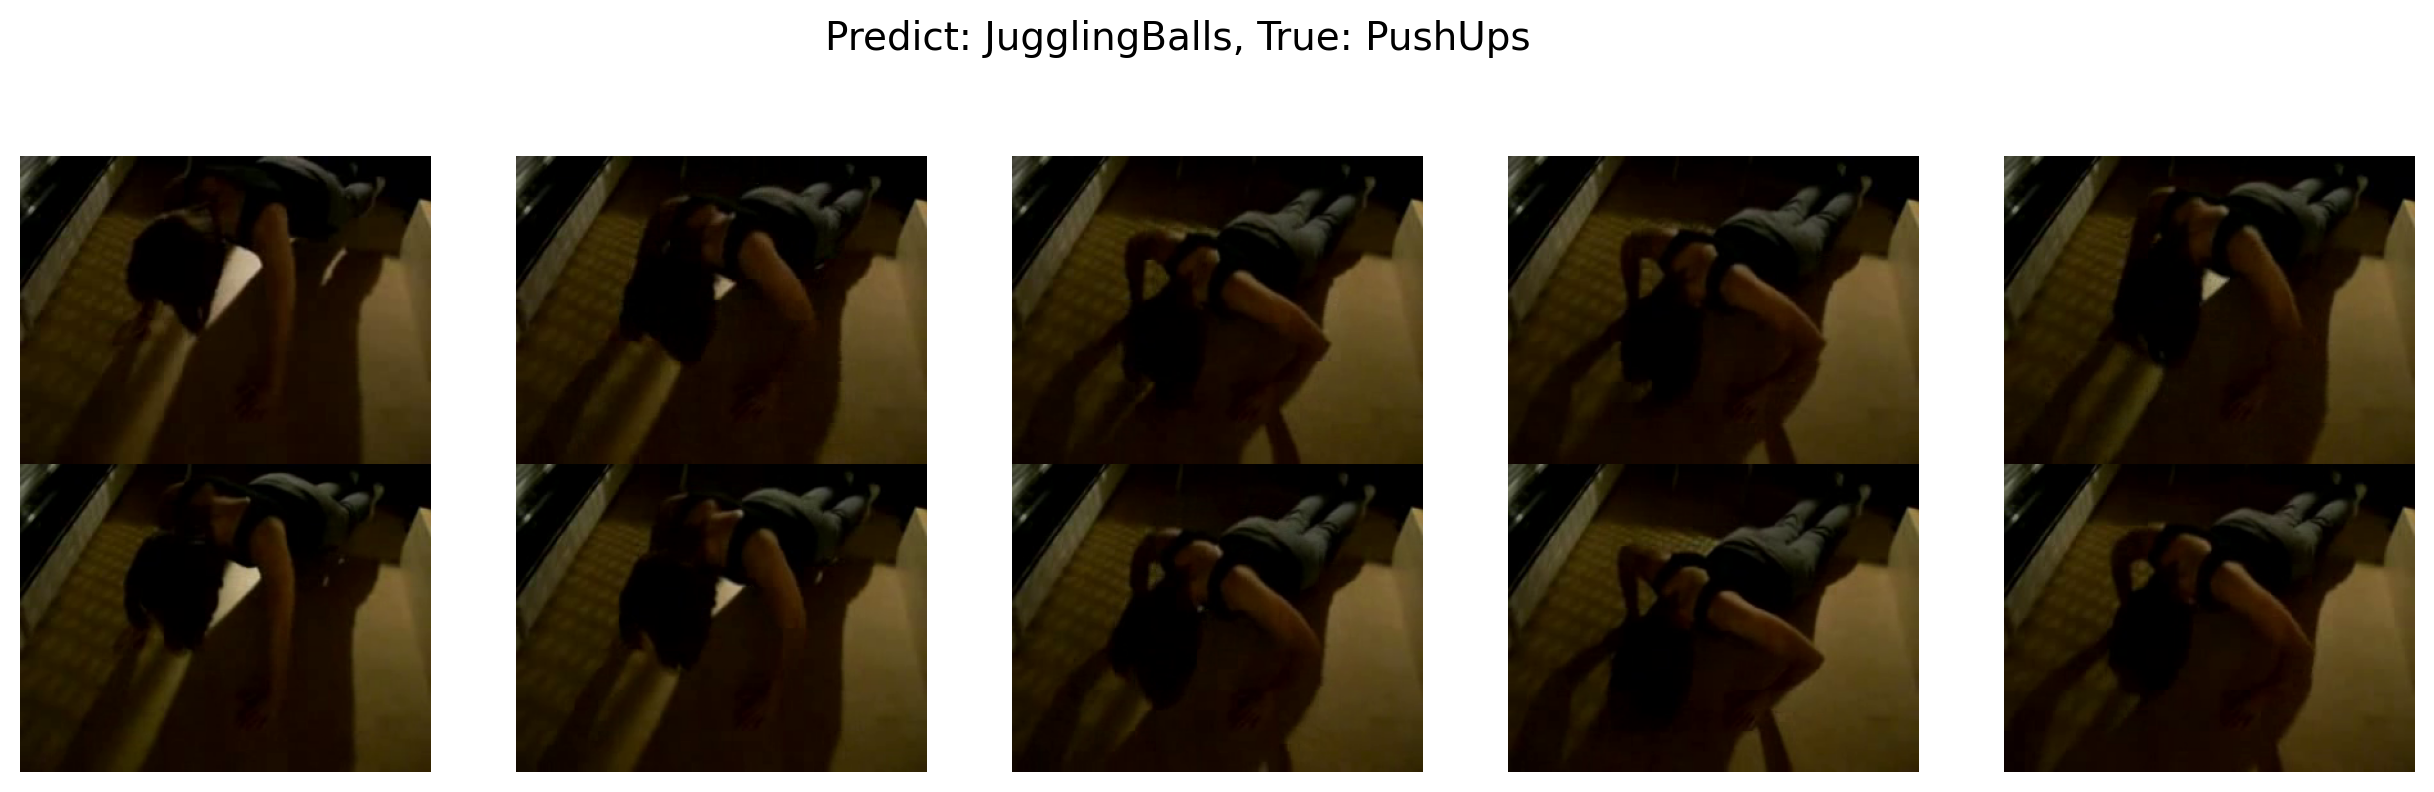

In [ ]:
def vidshow (*vid: torch.Tensor, true_label, predict_model = None, classes = None, device = 'cuda'):
    '''
    Take a [T, C, H, W] Tensor to plot.
    Tensor.dtype == 0-255 torch.float32
    '''
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['figure.dpi'] = 200
    plt.figure(figsize=(16, 4))

    if len (vid) == 2:
        vid_tensor, vid_augmented = vid[0].squeeze(), vid[1]
    else:
        vid_tensor = vid[0].squeeze()

    col = int (vid_tensor.shape[0] / 2)
    gs = gridspec.GridSpec(2, col, wspace=0.0, hspace=0.0)

    if predict_model:
        model.eval()
        with torch.inference_mode():
            vid_augmented = vid_augmented.to(device)
            test_pred_logits, test_fea = predict_model(vid_augmented)
            test_pred_labels = test_pred_logits.argmax(dim=1)

        predict_label = classes[test_pred_labels[0]]

    for i in range(2):
        for j in range(col):
            plt.subplot(gs[i, j])
            temp = vid_tensor[j+col*i, :] / 255.
            plt.imshow(temp.permute (1, 2, 0))
            plt.axis('off')

    plt.suptitle(f'Predict: {predict_label}, True: {true_label}', x=0.5, y=1.05, ha='center', fontsize=14)
    plt.show ()

# index = random.randrange (len (video_data))
# index = 4520
# print (f'Video index using: {index}')
# video = video_data.get_frames (index, use_offsets = True)
# _, label = video_data.get_label_idx (index)

X_augmented, y, X_orig = next (test_data_iterator)
label = video_data.classes[y]
vidshow (X_orig, X_augmented, true_label = label, predict_model = checkpoint_model, classes = video_data.classes)

In [ ]:
def check_num_frames (vid_paths, n_segment = 8):
    for path in vid_paths:
        vid_reader = vr (str (path))
        frames = []
        for frame in itertools.islice (vid_reader.seek (0, keyframes_only = True), n_segment):
            frames.append (frame['data'].to (dtype = torch.float))

        if len (frames) != n_segment:
            print (path)

vid_paths = list (Path (dataset_dir).glob ('*/*.avi'))
check_num_frames (vid_paths)

KeyboardInterrupt: ignored

In [ ]:
next (iter (test_data))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor([[[[-0.5253, -0.5253, -0.5253,  ..., -1.0219, -1.0048, -1.0219],
           [-0.5253, -0.5253, -0.5253,  ..., -1.0219, -1.0219, -1.0219],
           [-0.5424, -0.5424, -0.5424,  ..., -1.0219, -1.0219, -1.0219],
           ...,
           [-0.4226, -0.4397, -0.4226,  ..., -0.4739, -0.4739, -0.4911],
           [-0.3369, -0.3369, -0.3883,  ..., -0.5082, -0.5082, -0.5082],
           [-0.3027, -0.3027, -0.3541,  ..., -0.5253, -0.5253, -0.5253]],
 
          [[-0.4397, -0.4397, -0.4568,  ..., -0.5424, -0.5424, -0.5424],
           [-0.4568, -0.4568, -0.4568,  ..., -0.5596, -0.5424, -0.5424],
           [-0.4739, -0.4911, -0.4911,  ..., -0.5424, -0.5082, -0.5082],
           ...,
           [-0.4911, -0.4911, -0.4911,  ..., -0.5082, -0.5082, -0.5253],
           [-0.5082, -0.5082, -0.5253,  ..., -0.6281, -0.6281, -0.6281],
           [-0.5082, -0.5253, -0.5253,  ..., -0.6623, -0.6623, -0.6452]],
 
          [[-0.4568, -0.4568, -0.4568,  ..., -0.6794, -0.7822, -0.8335],
           [-

## Cuda Inspection

In [30]:
torch.cuda.empty_cache()

In [15]:
import gc
del model
gc.collect()

NameError: ignored

In [31]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 531807 KiB |  11032 MiB |   7054 GiB |   7054 GiB |
|       from large pool | 452608 KiB |  10991 MiB |   7051 GiB |   7050 GiB |
|       from small pool |  79199 KiB |     89 MiB |      3 GiB |      3 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 531807 KiB |  11032 MiB |   7054 GiB |   7054 GiB |
|       from large pool | 452608 KiB |  10991 MiB |   7051 GiB |

In [19]:
!nvidia-smi

Fri Oct 13 19:25:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |   1125MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
frm_idx = [11,  35,  59,  83, 107, 131, 154, 178, 202, 226, 250, 274]
frames = []
i = 0
print (vid)
stream = "video"
video_path = video_data.paths[4520]
vid = vr (str(video_path))
for frame in vid:
    frames.append (frame['data'])
len (frames)

275

In [ ]:
from torchvision.io import read_video
video_1 = read_video (video_path)
video_frames = []
for frame in itertools.islice(vid.seek(0), 0, 12*12, 12):
    video_frames.append (frame['data'])

print (len (video_frames))

# videos = torch.stack(video_frames, 0)
# print (video_1[0].dtype)

ValueError: ignored

In [ ]:
%cd UniFormer/video_classification
!python setup.py build develop

[Errno 2] No such file or directory: 'UniFormer/video_classification'
/content/UniFormer/video_classification
running build
running build_py
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ********************************************************************************

!!
  easy_install.initialize_options(self)
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Plea

In [14]:
def test (val = None):
    train_acc = 0
    train_loss = 0
    if val:
        val_acc = 0
        val_loss = 0
    return train_acc, train_loss if not val else train_acc, train_loss, val_acc, val_loss

test ([1,2])

(0, 0, 0, 0, 0)